# Candlestick body & pattern & return relationship

In [15]:
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import os
from pathlib import Path
import pandas_ta as ta
import pspriceaction.price_action as pa
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [16]:
data = []
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
algo_dir = current_dir.parent.parent
transform_csv_file = str(current_dir) + '/VN30F1M_5minutes_pattern.csv'
if os.path.isfile(transform_csv_file):
    data = pd.read_csv(transform_csv_file, index_col='Date', parse_dates=True)
    data['model'] = data['model'].fillna(value='')
else:
    csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
    is_file = os.path.isfile(csv_file)
    if is_file:
        dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
    else:
        dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)
    data = dataset.copy()
    data = pa.pattern_modeling(data)
    data.to_csv(transform_csv_file)

### Candlstick body rate & ibs

In [17]:
data['body_rate'] = data.apply(
    lambda r: 1 if (r['High'] == r['Low']) else abs(r['Open'] - r['Close']) / (r['High'] - r['Low']), axis=1)
data['ibs'] = data.apply(
    lambda r: 1 if (r['High'] == r['Low']) else abs(r['Close'] - r['Low']) / (r['High'] - r['Low']), axis=1)
data['body_rate'] = data['body_rate'].round(2)
data['ibs'] = data['ibs'].round(2)

### Calculating return

In [18]:
def has_bullish_pattern(model):
    if "bullish" in model or "rising" in model:
        return True
    return False

def has_bearish_pattern(model):
    if "bearish" in model or "falling" in model:
        return True
    return False

In [19]:
%%time
data['return'] = ''
data['signal'] = ''
data['exit_time'] = ''
# Stoploss at x0 pips
sl_step = 3
# Takeprofit at y0 pips(R/R = 1/3)
tp_step = 9
for i, row in data.iterrows():
    if has_bullish_pattern(row['model']):
        # Long signal
        data.at[i, 'signal'] = 'long'
        current_date = row.name.strftime('%Y-%m-%d ').format()
        current_time = row.name
        entry_price = row['Close']
        data_to_end_day = data[(data.index > current_time) & (data.index < current_date+' 14:30:00')]
        max_price = 0
        exit_time = ''
        for k, wrow in data_to_end_day.iterrows():
            if wrow['Low'] < entry_price and wrow['Low'] < entry_price - sl_step:
                # Stop loss
                momentum = -sl_step
                exit_time = wrow.name
                break
            else:
                if wrow['High'] > entry_price + tp_step:
                    # Take profit
                    momentum = tp_step
                    exit_time = wrow.name
                    break
                else:
                    # Close at 02:25PM
                    momentum = wrow['Close'] - entry_price
                    exit_time = wrow.name
        data.at[i, 'return'] = momentum
        data.at[i, 'exit_time'] = exit_time
    elif has_bearish_pattern(row['model']):
        # Short signal
        data.at[i, 'signal'] = 'short'
        current_date = row.name.strftime('%Y-%m-%d ').format()
        current_time = row.name
        entry_price = row['Close']
        data_to_end_day = data[(data.index > current_time) & (data.index < current_date+' 14:30:00')]
        min_price = 10000
        exit_time = ''
        for k, wrow in data_to_end_day.iterrows():
            if wrow['High'] > entry_price and wrow['High'] > entry_price + sl_step:
                # Stop loss
                momentum = -sl_step
                exit_time = wrow.name
                break
            else:
                if wrow['Low'] < entry_price - tp_step:
                    # Take profit
                    momentum = tp_step
                    exit_time = wrow.name
                    break
                else:
                    # Close at 02:25PM
                    momentum = entry_price - wrow['Close']
                    exit_time = wrow.name
        data.at[i, 'return'] = momentum
        data.at[i, 'exit_time'] = exit_time

CPU times: user 18.3 s, sys: 6.41 ms, total: 18.4 s
Wall time: 18.4 s


### Return Analytics

In [20]:
has_return = data[data['return'] != '']
#----
long_return = has_return[has_return['signal'] == 'long']
short_return = has_return[has_return['signal'] == 'short']
#----
negative_return = has_return[has_return['return'] < 0]
positive_return = has_return[has_return['return'] > 0]
#----
short_negative_return = short_return[short_return['return'] < 0]
short_positive_return = short_return[short_return['return'] > 0]
long_negative_return = long_return[long_return['return'] < 0]
long_positive_return = long_return[long_return['return'] > 0]

### Body rate & ibs & return relationship

In [27]:
# k = long_return.groupby(['ibs'])[['ibs']].count()
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(k)

In [24]:
long_return['body_rate_group'] = pd.cut(long_return['body_rate'], 20)
long_return['ibs_group'] = pd.cut(long_return['ibs'], 20)
# sum return after group of long
lsg = long_return.groupby(['body_rate_group', 'ibs_group'])[['return']].sum()
lsg = lsg.reset_index()
lsg_pivot = lsg.pivot(index="body_rate_group", columns="ibs_group", values="return").sort_index(ascending=False)
lsg_pivot = lsg_pivot[lsg_pivot.columns].astype(float)

In [25]:
lsg_pivot

ibs_group,"(-0.001, 0.05]","(0.05, 0.1]","(0.1, 0.15]","(0.15, 0.2]","(0.2, 0.25]","(0.25, 0.3]","(0.3, 0.35]","(0.35, 0.4]","(0.4, 0.45]","(0.45, 0.5]","(0.5, 0.55]","(0.55, 0.6]","(0.6, 0.65]","(0.65, 0.7]","(0.7, 0.75]","(0.75, 0.8]","(0.8, 0.85]","(0.85, 0.9]","(0.9, 0.95]","(0.95, 1.0]"
body_rate_group,,,,,,,,,,,,,,,,,,,,
"(0.95, 1.0]",65.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,437.7
"(0.901, 0.95]",0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125.2,156.6
"(0.852, 0.901]",5.8,-3.0,-3.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172.9,50.9,78.9
"(0.802, 0.852]",9.0,0.0,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8,34.4,0.3,48.6
"(0.753, 0.802]",-6.0,-2.5,18.0,9.0,-1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.2,35.3,78.7,9.5,57.2
"(0.703, 0.753]",8.3,-9.0,-9.0,6.0,-12.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.5,57.4,11.4,40.0,28.0,3.7
"(0.654, 0.703]",15.5,-3.0,-4.1,-6.0,-1.3,9.9,0.1,0.0,0.0,0.0,0.0,0.0,0.0,83.2,11.0,19.1,-18.2,-2.3,-30.5,110.5
"(0.604, 0.654]",8.0,-10.9,-3.0,-2.6,-3.5,-3.0,11.9,-1.0,0.0,0.0,0.0,0.0,17.5,55.7,30.1,-6.6,33.9,43.3,-17.4,-2.8
"(0.554, 0.604]",-3.8,26.6,2.4,-7.9,4.1,-4.7,0.0,-12.2,-10.6,0.0,0.0,57.6,-2.5,48.6,31.8,57.6,-9.1,34.8,-11.2,12.3


<Axes: xlabel='ibs_group', ylabel='body_rate_group'>

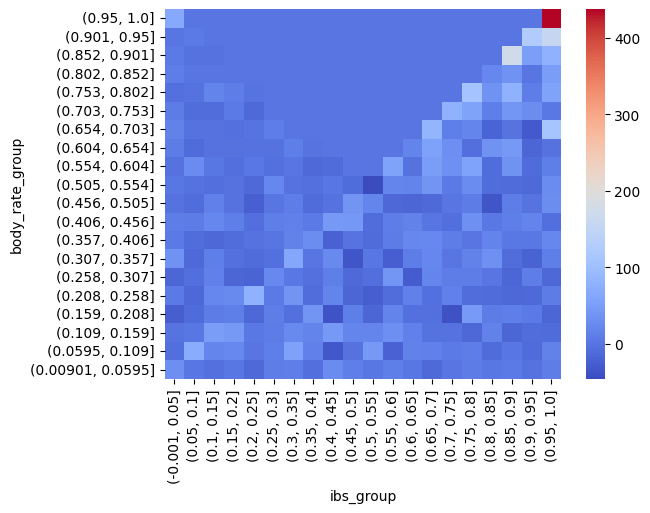

In [26]:
sns.heatmap(lsg_pivot, cmap = 'coolwarm')

In [28]:
short_return['body_rate_group'] = pd.cut(short_return['body_rate'], 20)
short_return['ibs_group'] = pd.cut(short_return['ibs'], 20)
# sum return after group of long
ssg = short_return.groupby(['body_rate_group', 'ibs_group'])[['return']].sum()
ssg = ssg.reset_index()
ssg_pivot = ssg.pivot(index="body_rate_group", columns="ibs_group", values="return").sort_index(ascending=False)
ssg_pivot = ssg_pivot[ssg_pivot.columns].astype(float)

In [30]:
ssg_pivot

ibs_group,"(-0.00096, 0.048]","(0.048, 0.096]","(0.096, 0.144]","(0.144, 0.192]","(0.192, 0.24]","(0.24, 0.288]","(0.288, 0.336]","(0.336, 0.384]","(0.384, 0.432]","(0.432, 0.48]","(0.48, 0.528]","(0.528, 0.576]","(0.576, 0.624]","(0.624, 0.672]","(0.672, 0.72]","(0.72, 0.768]","(0.768, 0.816]","(0.816, 0.864]","(0.864, 0.912]","(0.912, 0.96]"
body_rate_group,,,,,,,,,,,,,,,,,,,,
"(0.95, 1.0]",224.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0.901, 0.95]",16.4,59.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0.852, 0.901]",46.3,-10.7,137.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0.802, 0.852]",42.6,-3.4,33.4,67.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0.753, 0.802]",-2.7,15.6,26.0,29.3,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0.703, 0.753]",4.1,6.7,88.4,-3.7,-12.4,46.7,54.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0.654, 0.703]",-0.1,12.3,8.2,49.8,27.7,37.8,59.8,-3.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0.604, 0.654]",8.6,6.0,1.4,40.6,18.2,-17.6,53.0,0.9,-12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0.554, 0.604]",44.6,-12.0,1.7,-9.5,3.7,-4.3,38.5,22.5,82.5,10.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='ibs_group', ylabel='body_rate_group'>

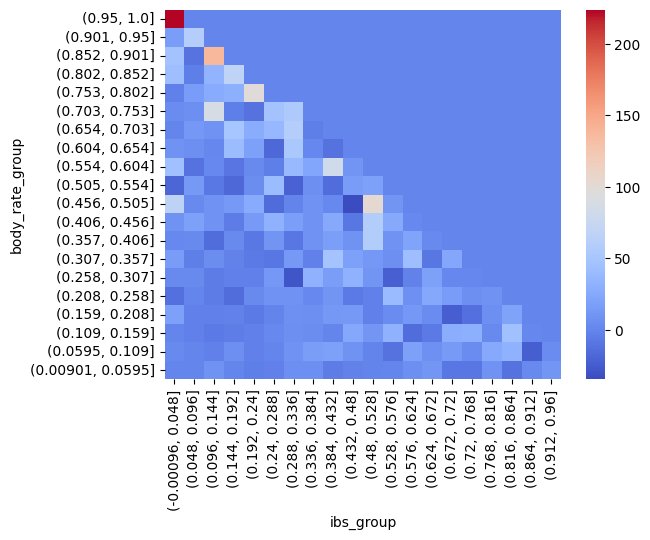

In [31]:
sns.heatmap(ssg_pivot, cmap = 'coolwarm')